# Free-form chip-to-chip coupler

The efficient transfer of light between optical waveguides on separate chips is crucial for applications in photonic chip interfacing with optical interposers, flexible waveguide ribbons, and communication in multi-chip modules, as well as for connecting chips to optical printed circuit boards (PCBs). Historically, this inter-chip coupling has been achieved using mirrors or grating couplers. However, the mirror method faces challenges in achieving high coupling efficiency due to unavoidable wavefront distortions, while grating couplers suffer from inherent wavelength sensitivity. A new coupling scheme based on microfabricated free-form optical reflectors has been proposed, which offers low coupling loss, large bandwidth, high density, polarization diversity, and superior alignment tolerance.

This notebook demonstrates the simulation and optimization of a free-form chip-to-chip coupler based on the work `S. Yu, H. Zuo, X. Sun, J. Liu, T. Gu and J. Hu, "Optical Free-Form Couplers for High-density Integrated Photonics (OFFCHIP): A Universal Optical Interface," in Journal of Lightwave Technology, vol. 38, no. 13, pp. 3358-3365, 1 July, 2020.` [DOI: 10.1109/JLT.2020.2971724](https://doi.org/10.1109/JLT.2020.2971724). The coupler consists of two parabolic reflectors. The geometry is constructed using external CAD software and imported into `Tidy3D` for FDTD simulations. The initial design is based on ray optics where we assume the optical waveguide facets on both chips are located at the two focal points of the reflectors. This is not optimal due to the wave nature of light and the waveguide mode not being a point source so the positions of the waveguides are tuned to improve the insertion loss. Besides chip-to-chip coupling, this type of free-form couplers can also be used for fiber-to-chip coupling. 

<img src="img/freeform_coupler.png" width="400" alt="Schematic of the Free-form Coupler">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

## Simulation Setup

Define the simulation wavelength range to be 650 nm to 1050 nm.

In [2]:
lda0 = 0.85  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(0.65, 1.05, 21)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency

The free-form coupler is designed for low-contrast waveguide systems. Here we define the waveguide core and cladding materials.

In [3]:
n_core = 1.543
mat_core = td.Medium(permittivity=n_core**2)

n_clad = 1.525
mat_clad = td.Medium(permittivity=n_clad**2)

Next, define geometric parameters for the waveguide as well as the coupler.

In [4]:
w_core = 2.3  # waveguide core width
t_core = 2.3  # waveguide core thickness
l_coupler = 40  # length of the coupler
h_coupler = 45  # thickness of the coupler
y_focus_1 = 0  # y coordinate of the coupler's first focus
y_focus_2 = 25  # y coordinate of the coupler's second focus
t_clad = (y_focus_2 - y_focus_1) / 2  # thickness of the cladding
buffer_x = 10  # buffer spacing in x
buffer_y = 5  # buffer spacing in y
inf_eff = 1e3  # effective infinity

For the best focusing performance, the free-form coupler has a parabolic shape. We used an external CAD package to create the geometry and import it into Tidy3D. The design principle is adopted from ray optics and can be found in standard optics textbooks. 

In fact, simply putting the waveguide facet at the focus of the parabolic coupler will not result in optimal coupling efficiency since the waveguide mode is not a point source. Therefore, the position of the coupler needs to be fine-tuned for optimal coupling efficiency. To do so, we create a function `make_structures(adjustable_spacing)` that defines the simulation structures giving the offset spacing in the $x$ direction.

In [5]:
def make_structures(adjustable_spacing):

    # import coupler geometry from a stl file
    coupler_geometry = td.TriangleMesh.from_stl(
        filename="misc/chip_to_chip_coupler.stl",
    )

    # define coupler structure
    coupler = td.Structure(geometry=coupler_geometry, medium=mat_core)

    # define the structures for additional offset in x
    adjust_in = td.Structure(
        geometry=td.Box(
            center=(adjustable_spacing / 2, 0, 0),
            size=(abs(adjustable_spacing), 2 * t_clad, td.inf),
        ),
        medium=mat_clad if adjustable_spacing > 0 else mat_core,
    )

    adjust_out = td.Structure(
        geometry=td.Box(
            center=(l_coupler - adjustable_spacing / 2, y_focus_2, 0),
            size=(abs(adjustable_spacing), 2 * t_clad, td.inf),
        ),
        medium=mat_clad if adjustable_spacing > 0 else mat_core,
    )

    # define the input waveguide structure
    waveguide_in = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -t_core / 2, -w_core / 2),
            rmax=(adjustable_spacing, t_core / 2, w_core / 2),
        ),
        medium=mat_core,
    )

    # define the output waveguide structure
    waveguide_out = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(l_coupler - adjustable_spacing, y_focus_2 - t_core / 2, -w_core / 2),
            rmax=(inf_eff, y_focus_2 + t_core / 2, w_core / 2),
        ),
        medium=mat_core,
    )

    # define the input waveguide cladding structure
    clad_in = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(adjustable_spacing, t_clad, inf_eff)
        ),
        medium=mat_clad,
    )

    # define the output waveguide cladding structure
    clad_out = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(l_coupler - adjustable_spacing, y_focus_2 - t_clad, -inf_eff),
            rmax=(inf_eff, inf_eff, inf_eff),
        ),
        medium=mat_clad,
    )

    if adjustable_spacing != 0:
        return [coupler, adjust_in, adjust_out, clad_in, clad_out, waveguide_in, waveguide_out]
    else:
        return [coupler, clad_in, clad_out, waveguide_in, waveguide_out]

Next we define the source and monitors. Then put everything into a Tidy3D [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) object. To facilitate parameter sweep to optimize the coupling efficiency, we put everything into a function.

In [6]:
def make_sim(adjustable_spacing):

    # add a mode source as excitation
    mode_spec = td.ModeSpec(num_modes=1, target_neff=n_core)
    mode_source = td.ModeSource(
        center=(adjustable_spacing - 0.9 * buffer_x, 0, 0),
        size=(0, 5 * t_core, 5 * w_core),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
        num_freqs=7,
    )

    # add a mode monitor to measure transmission at the output waveguide
    mode_monitor = td.ModeMonitor(
        center=(l_coupler - adjustable_spacing + 0.9 * buffer_x, y_focus_2, 0),
        size=mode_source.size,
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode",
    )

    # add a field monitor to visualize field distribution at z=t/2
    field_monitor = td.FieldMonitor(
        center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
    )

    # simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(adjustable_spacing - buffer_x, y_focus_1 - buffer_y, -2 * w_core),
        rmax=(l_coupler - adjustable_spacing + buffer_x, y_focus_2 + buffer_y, 2 * w_core),
    )

    run_time = 1e-12  # simulation run time

    # define simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=10, wavelength=lda0),
        structures=make_structures(adjustable_spacing),
        sources=[mode_source],
        monitors=[mode_monitor, field_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        symmetry=(0, 0, -1),
    )

    return sim

Visualize the simulation using an arbitrary parameter to verify everything is set up properly.

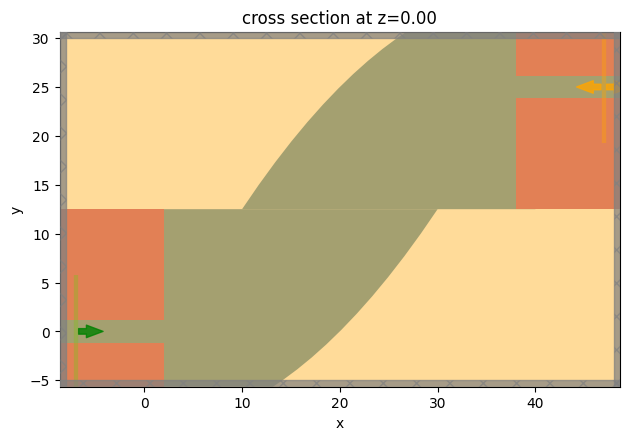

In [7]:
sim = make_sim(adjustable_spacing=2)
sim.plot(z=0)
plt.show()

## Parameter Sweep

Now we are ready to perform the parameter sweep and monitor the coupling efficiency as a function of the $x$ offset. Since this is just a simple parameter sweep over one variable, we will use the batch feature in Tidy3D. For more complex parameter sweep and design parameter space exploration, we recommend using Tidy3D's [design plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/) as demonstrated in this [example](https://www.flexcompute.com/tidy3d/examples/notebooks/AllDielectricStructuralColor/).

In [8]:
# parameter sweep range
adjustable_spacing_list = np.linspace(-1, 4, 6)

# create a batch and run it
sims = {
    f"{adjustable_spacing:.1f} μm": make_sim(adjustable_spacing)
    for adjustable_spacing in adjustable_spacing_list
}
batch = web.Batch(simulations=sims, verbose=False)
batch_results = batch.run(path_dir="data")

From the plotted results, we see that the coupling efficiency is around 0.5 dB for 3 or 4 μm offset in the $x$ direction.

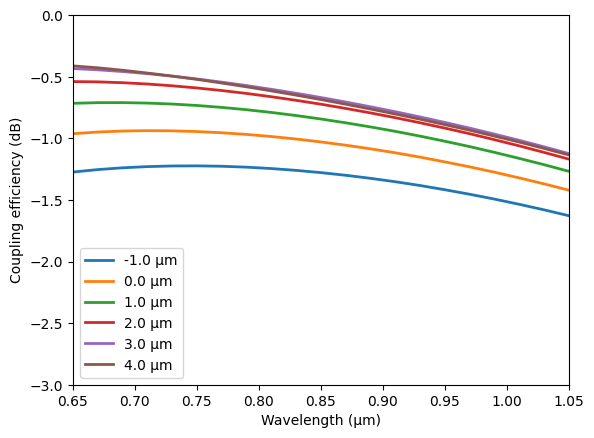

In [9]:
# extract and plot coupling efficiencies from all simulations
for adjustable_spacing in adjustable_spacing_list:
    sim_data = batch_results[f"{adjustable_spacing} μm"]
    T = np.abs(sim_data["mode"].amps.sel(direction="+").values) ** 2

    plt.plot(ldas, 10 * np.log10(T), linewidth=2, label=f"{adjustable_spacing} μm")

plt.xlabel("Wavelength (μm)")
plt.ylabel("Coupling efficiency (dB)")
plt.xlim(min(ldas), max(ldas))
plt.ylim(-3, 0)
plt.legend()
plt.show()

Finally, visualize the field intensity distribution for the optimal coupling efficiency. 

Additional optimization can be done by further fine tuning the parabolic reflector shape. 

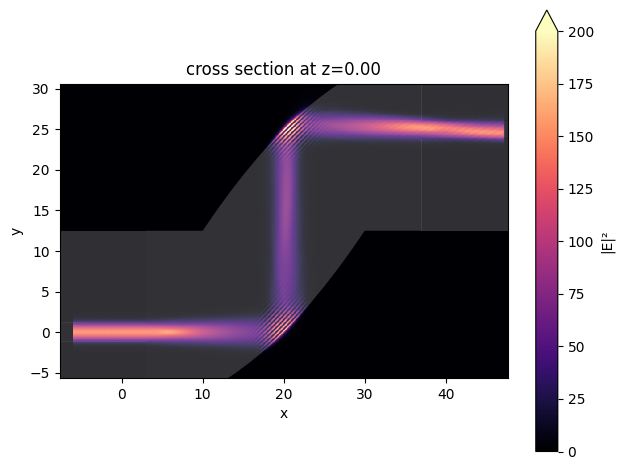

In [10]:
batch_results["3.0 μm"].plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", eps_alpha=0.2, vmin=0, vmax=200
)
plt.show()